# Online Gradient Descent

In [ ]:
# Standard data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Financial data
import yfinance as yf

# System utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Preparing backtesting for purposes of comparison

In [ ]:
def run_backtest(tickers, portfolio_weights, start_date='2023-01-01'):
    """
    Run a backtest of a portfolio allocation strategy

    Parameters:
    tickers (list): List of stock tickers
    portfolio_weights (np.array): Matrix of shape (n_stocks, n_days) with daily portfolio weights
    start_date (str): Start date for the backtest

    Returns:
    float: Aggregate fitness score
    dict: Additional metrics for analysis
    """
    # Input validation
    assert len(tickers) == portfolio_weights.shape[0], "Number of tickers must match number of rows in weights"
    assert np.allclose(np.sum(portfolio_weights, axis=0), 1), "Portfolio weights must sum to 1 for each day"
    assert np.all(portfolio_weights >= 0), "Portfolio weights must be non-negative"

    # Download historical data
    end_date = (datetime.strptime(start_date, '%Y-%m-%d') +
                timedelta(days=portfolio_weights.shape[1])).strftime('%Y-%m-%d')

    # Modified data downloading approach
    stock_data = pd.DataFrame()
    for ticker in tickers:
        # Download data for each ticker
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(start=start_date, end=end_date)
        if 'Close' in hist.columns:  # Use 'Close' instead of 'Adj Close'
            stock_data[ticker] = hist['Close']
        else:
            raise ValueError(f"Could not get price data for {ticker}")

    # Ensure we have data
    if stock_data.empty:
        raise ValueError("No data was downloaded for any ticker")

    # Calculate daily returns
    daily_returns = stock_data.pct_change()
    daily_returns = daily_returns.fillna(0)

    # Adjust portfolio_weights to match the actual number of days in our data
    if portfolio_weights.shape[1] > len(daily_returns):
        portfolio_weights = portfolio_weights[:, :len(daily_returns)]

    # Calculate portfolio returns
    portfolio_returns = np.zeros(len(daily_returns) - 1)

    for day in range(len(portfolio_returns)):
        day_weights = portfolio_weights[:, day]
        next_day_returns = daily_returns.iloc[day+1].values
        portfolio_returns[day] = np.sum(day_weights * next_day_returns)

    return calculate_fitness(portfolio_returns)

Calculating the fitness (our objective function) given returns data

In [ ]:
def calculate_fitness(returns, risk_free_rate=0.04):
    """
    Calculate the fitness score for a portfolio

    Parameters:
    returns (np.array): Array of daily portfolio returns
    risk_free_rate (float): Annual risk-free rate

    Returns:
    float: Fitness score
    """
    # Convert annual risk-free rate to daily
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1

    # Calculate key metrics
    portfolio_return = np.mean(returns) * 252  # Annualized return
    portfolio_volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Maximum drawdown calculation
    cumulative_returns = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdowns)

    # Combined fitness score (can be modified based on preferences)
    fitness = (0.4 * sharpe_ratio +
              0.3 * portfolio_return +
              0.3 * (1 + max_drawdown))  # Add 1 to make max_drawdown positive

    return fitness

Normalize weights so they add up to 1

In [ ]:
def project_onto_simplex(weights):
    """
    Project weights onto the probability simplex (non-negative, sum to 1)
    Using the algorithm from: https://arxiv.org/abs/1309.1541

    Parameters:
    weights (np.array): Input weights to project

    Returns:
    np.array: Projected weights that sum to 1 and are non-negative
    """
    # Sort weights in descending order
    u = np.sort(weights)[::-1]
    cssv = np.cumsum(u) - 1  # Cumulative sum minus 1
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > cssv)[0][-1]
    theta = cssv[rho] / (rho + 1)

    # Project onto simplex
    return np.maximum(weights - theta, 0)

Calculate the metrics necessary to give fitness score

In [ ]:
def calculate_metrics(returns_window, risk_free_rate=0.04):
    """
    Calculate key portfolio metrics over a window of returns

    Parameters:
    returns_window (np.array): Array of historical returns
    risk_free_rate (float): Annual risk-free rate

    Returns:
    tuple: (sharpe_ratio, portfolio_return, max_drawdown)
    """
    if len(returns_window) == 0:
        return 0, 0, 0

    # Convert annual risk-free rate to daily
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1

    # Calculate returns and volatility
    portfolio_return = np.mean(returns_window) * 252
    portfolio_volatility = np.std(returns_window) * np.sqrt(252)

    # Sharpe ratio
    sharpe_ratio = 0 if portfolio_volatility == 0 else (portfolio_return - risk_free_rate) / portfolio_volatility

    # Maximum drawdown
    cumulative_returns = np.cumprod(1 + returns_window)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdowns)

    return sharpe_ratio, portfolio_return, max_drawdown

Portfolio optimizer class

In [ ]:
class OnlinePortfolioOptimizer:
    def __init__(self, n_assets, learning_rate=0.01, window_size=30):
        """
        Initialize the online portfolio optimizer

        Parameters:
        n_assets (int): Number of assets in portfolio
        learning_rate (float): Learning rate for gradient updates
        window_size (int): Window size for calculating metrics
        """
        self.n_assets = n_assets
        self.learning_rate = learning_rate
        self.window_size = window_size

        # Initialize weights equally
        self.weights = np.ones(n_assets) / n_assets
        self.returns_history = []

    def calculate_gradient(self, daily_returns):
        """
        Calculate the gradient for weight updates

        Parameters:
        daily_returns (np.array): Array of asset returns for the current day

        Returns:
        np.array: Gradient for weight updates
        """
        # Store the current day's portfolio return
        portfolio_return = np.sum(self.weights * daily_returns)
        self.returns_history.append(portfolio_return)

        # If we don't have enough history, use a simple return gradient
        if len(self.returns_history) < self.window_size:
            return daily_returns - np.mean(daily_returns)

        # Calculate metrics over the window
        returns_window = np.array(self.returns_history[-self.window_size:])
        sharpe, returns, drawdown = calculate_metrics(returns_window)

        # Gradient components
        return_gradient = daily_returns
        volatility_gradient = -2 * (daily_returns - np.mean(returns_window))

        # Combine gradients (weights can be adjusted)
        gradient = (0.4 * return_gradient +
                   0.3 * volatility_gradient +
                   0.3 * return_gradient)  # Simplified drawdown gradient

        return gradient

    def update(self, daily_returns):
        """
        Update portfolio weights based on the day's returns

        Parameters:
        daily_returns (np.array): Array of asset returns for the current day

        Returns:
        np.array: Updated portfolio weights
        """
        # Calculate gradient
        gradient = self.calculate_gradient(daily_returns)

        # Update weights using gradient ascent
        self.weights += self.learning_rate * gradient

        # Project weights onto simplex
        self.weights = project_onto_simplex(self.weights)

        return self.weights

Day 0: Portfolio Return = 0.0000
Day 30: Portfolio Return = 0.0064
Day 60: Portfolio Return = 0.0098
Day 90: Portfolio Return = -0.0084
Day 120: Portfolio Return = 0.0211
Day 150: Portfolio Return = -0.0215
Day 180: Portfolio Return = -0.0213
Day 210: Portfolio Return = 0.0188
Day 240: Portfolio Return = 0.0084
Day 270: Portfolio Return = -0.0300
Day 300: Portfolio Return = -0.0015
Day 330: Portfolio Return = 0.0289
Day 360: Portfolio Return = 0.0023
Day 390: Portfolio Return = -0.0564
Day 420: Portfolio Return = 0.0149
Day 450: Portfolio Return = 0.0001
Day 480: Portfolio Return = 0.0126
Day 510: Portfolio Return = 0.0366

Final Portfolio Metrics:
Sharpe Ratio: 2.3852
Annualized Return: 0.6439
Maximum Drawdown: -0.1736


<Figure size 1200x600 with 0 Axes>

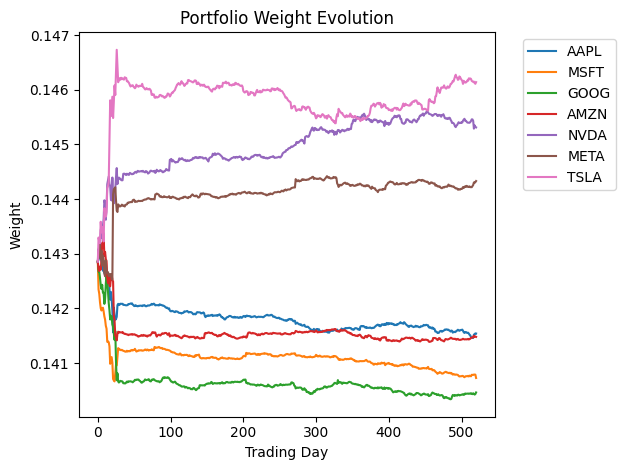

In [ ]:
# Initialize data and optimizer
mag_seven = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA']
start_date = '2023-01-01'

# Download historical data
stock_data = pd.DataFrame()
for ticker in mag_seven:
    ticker_obj = yf.Ticker(ticker)
    hist = ticker_obj.history(start=start_date)
    stock_data[ticker] = hist['Close']

# Calculate daily returns
daily_returns = stock_data.pct_change()
daily_returns = daily_returns.fillna(0)

# Initialize optimizer
optimizer = OnlinePortfolioOptimizer(len(mag_seven), learning_rate=0.01)

# Training loop
weight_history = []
portfolio_returns = []

for t in range(len(daily_returns)):
    # Get current day's returns
    current_returns = daily_returns.iloc[t].values

    # Update portfolio weights
    weights = optimizer.update(current_returns)
    weight_history.append(weights.copy())

    # Calculate portfolio return for the day
    portfolio_return = np.sum(weights * current_returns)
    portfolio_returns.append(portfolio_return)

    # Print progress every 30 days
    if t % 30 == 0:
        print(f"Day {t}: Portfolio Return = {portfolio_return:.4f}")

# Convert weight history to DataFrame for analysis
weight_df = pd.DataFrame(weight_history, columns=mag_seven)

# Calculate final metrics
final_returns = np.array(portfolio_returns)
sharpe, returns, drawdown = calculate_metrics(final_returns)

print("\nFinal Portfolio Metrics:")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Annualized Return: {returns:.4f}")
print(f"Maximum Drawdown: {drawdown:.4f}")

# Plot weight evolution
plt.figure(figsize=(12, 6))
weight_df.plot(title='Portfolio Weight Evolution')
plt.xlabel('Trading Day')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate fitness for online optimization results
print("Comparing Strategies:")
print("-" * 50)

# First calculate fitness for online optimization
online_opt_returns = np.array(portfolio_returns)
online_fitness = calculate_fitness(online_opt_returns)
print(f"{'Online Optimization':<20} : {online_fitness:>10.4f}")

# Calculate fitness for individual stocks and equal weight
results = []

# Individual stock investments
for i, ticker in enumerate(mag_seven):
    weights = np.zeros((len(mag_seven), len(daily_returns)))
    weights[i, :] = 1  # Full investment in single stock

    # Calculate returns for this strategy
    strategy_returns = np.array([np.sum(weights[:, t] * daily_returns.iloc[t].values)
                               for t in range(len(daily_returns))])

    # Calculate fitness
    fitness = calculate_fitness(strategy_returns)
    results.append((ticker, fitness))
    print(f"{ticker:<20} : {fitness:>10.4f}")

# Equal weight strategy
equal_weights = np.ones((len(mag_seven), len(daily_returns))) / len(mag_seven)
equal_returns = np.array([np.sum(equal_weights[:, t] * daily_returns.iloc[t].values)
                         for t in range(len(daily_returns))])
equal_fitness = calculate_fitness(equal_returns)
print(f"{'Equal Weight':<20} : {equal_fitness:>10.4f}")

# Print summary stats
print("\nStrategy Rankings:")
print("-" * 50)
all_results = results + [("Equal Weight", equal_fitness), ("Online Opt", online_fitness)]
sorted_results = sorted(all_results, key=lambda x: x[1], reverse=True)

for rank, (strategy, fitness) in enumerate(sorted_results, 1):
    print(f"{rank}. {strategy:<20} : {fitness:>10.4f}")

Comparing Strategies:
--------------------------------------------------
Online Optimization  :     1.3952
AAPL                 :     0.9051
MSFT                 :     0.7930
GOOG                 :     0.9129
AMZN                 :     1.0524
NVDA                 :     1.4428
META                 :     1.4212
TSLA                 :     0.9084
Equal Weight         :     1.3931

Strategy Rankings:
--------------------------------------------------
1. NVDA                 :     1.4428
2. META                 :     1.4212
3. Online Opt           :     1.3952
4. Equal Weight         :     1.3931
5. AMZN                 :     1.0524
6. GOOG                 :     0.9129
7. TSLA                 :     0.9084
8. AAPL                 :     0.9051
9. MSFT                 :     0.7930


# Below this line is testing for next week; Please ignore

In [ ]:
def generate_training_dataset(tickers, lookback_days=10, start_date='2022-01-01', end_date='2022-12-31',
                            n_optimization_trials=10, regularization_lambda=0.01):
    """
    Generate training dataset for portfolio optimization

    Parameters:
    tickers (list): List of stock tickers
    lookback_days (int): Number of days of historical data to use as input
    start_date (str): Start date for data collection
    end_date (str): End date for data collection
    n_optimization_trials (int): Number of random initializations for finding optimal weights
    regularization_lambda (float): Regularization parameter for weight diversity

    Returns:
    tuple: (X, y) where X is historical returns and y is optimal weights
    """
    # Download historical data
    stock_data = pd.DataFrame()
    for ticker in tickers:
        ticker_obj = yf.Ticker(ticker)
        hist = ticker_obj.history(start=start_date, end=end_date)
        stock_data[ticker] = hist['Close']

    # Calculate daily returns
    daily_returns = stock_data.pct_change()
    daily_returns = daily_returns.fillna(0)

    # Initialize lists for inputs (X) and labels (y)
    X = []
    y = []

    def find_optimal_weights(day_returns, historical_returns):
        """Find optimal weights for a given day using multiple random initializations"""
        best_fitness = float('-inf')
        best_weights = None

        for _ in range(n_optimization_trials):
            # Random initialization
            weights = np.random.random(len(tickers))
            weights = weights / np.sum(weights)

            # Simple gradient ascent
            learning_rate = 0.05
            for _ in range(100):  # Number of optimization steps
                # Calculate fitness with regularization
                portfolio_return = np.sum(weights * day_returns)
                historical_portfolio_returns = np.append(historical_returns, portfolio_return)

                fitness = calculate_fitness(historical_portfolio_returns)
                # Add regularization term to encourage diversity
                regularization = -regularization_lambda * np.sum(weights * np.log(weights + 1e-10))
                total_fitness = fitness + regularization

                if total_fitness > best_fitness:
                    best_fitness = total_fitness
                    best_weights = weights.copy()

                # Gradient approximation
                grad = np.zeros_like(weights)
                eps = 1e-7
                for i in range(len(weights)):
                    weights_plus = weights.copy()
                    weights_plus[i] += eps
                    weights_plus = weights_plus / np.sum(weights_plus)

                    portfolio_return_plus = np.sum(weights_plus * day_returns)
                    historical_plus = np.append(historical_returns, portfolio_return_plus)
                    fitness_plus = calculate_fitness(historical_plus)
                    reg_plus = -regularization_lambda * np.sum(weights_plus * np.log(weights_plus + 1e-10))

                    grad[i] = (fitness_plus + reg_plus - total_fitness) / eps

                # Update weights
                weights += learning_rate * grad
                weights = np.maximum(weights, 0)  # Ensure non-negative
                weights = weights / np.sum(weights)  # Project onto simplex

        return best_weights

    # Generate training examples
    for t in range(lookback_days, len(daily_returns) - 1):
        # Input: returns for the past lookback_days
        historical_window = daily_returns.iloc[t-lookback_days:t].values
        X.append(historical_window.flatten())  # Flatten to 1D array

        # Output: optimal weights for next day
        next_day_returns = daily_returns.iloc[t+1].values
        historical_returns = daily_returns.iloc[t-lookback_days:t+1].mean(axis=1).values
        optimal_weights = find_optimal_weights(next_day_returns, historical_returns)
        y.append(optimal_weights)

    return np.array(X), np.array(y)

In [ ]:
mag_seven = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA']

# Generate dataset
X, y = generate_training_dataset(mag_seven, lookback_days=10)

# Print dataset information
print(f"Dataset shape:")
print(f"X shape: {X.shape}")  # Should be (n_samples, n_stocks * lookback_days)
print(f"y shape: {y.shape}")  # Should be (n_samples, n_stocks)

# Print example
print("\nExample training instance:")
print("Input returns shape:", X[0].reshape(10, len(mag_seven)).shape)
print("Target weights:", y[0])
print("Sum of weights:", np.sum(y[0]))  # Should be close to 1.0

Dataset shape:
X shape: (240, 70)
y shape: (240, 7)

Example training instance:
Input returns shape: (10, 7)
Target weights: [0. 0. 0. 0. 0. 1. 0.]
Sum of weights: 1.0



Strategy Performance Comparison (2022)
--------------------------------------------------
Strategy           Fitness  Relative to EW
--------------------------------------------------
MSFT               -0.1217          -75.5%
AAPL               -0.1552          -68.8%
NVDA               -0.3122          -37.2%
GOOG               -0.3987          -19.7%
Dataset Optimal    -0.4634           -6.7%
AMZN               -0.4935           -0.7%
Equal Weight       -0.4968            0.0%
META               -0.7038           41.6%
TSLA               -0.7350           47.9%


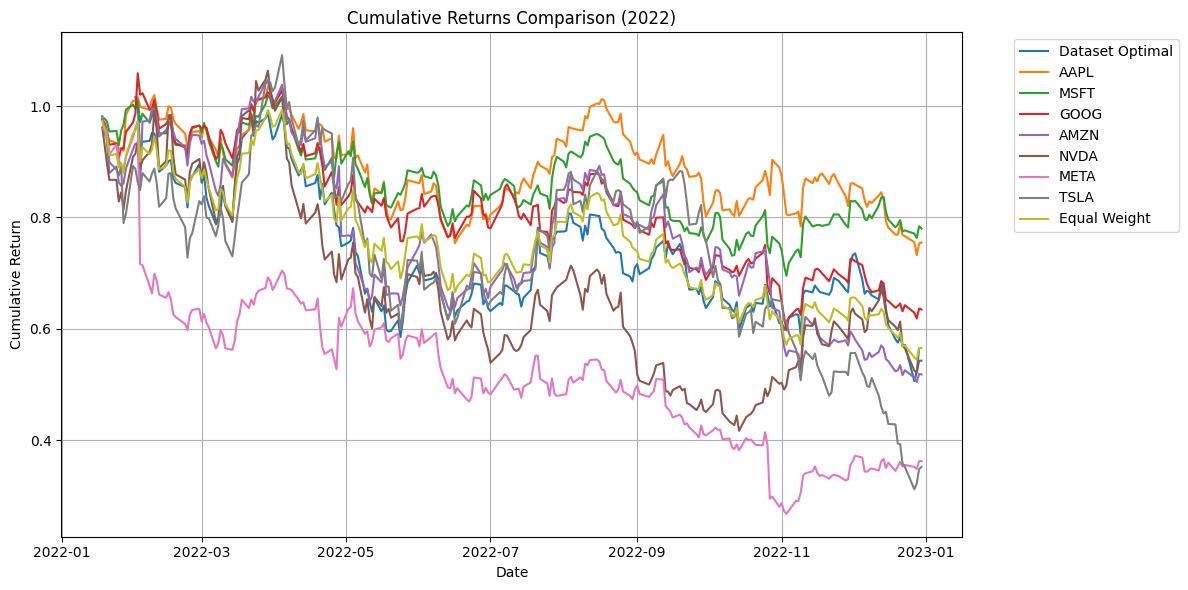


Detailed Performance Metrics
--------------------------------------------------
                  Dataset Optimal   AAPL   MSFT   GOOG   AMZN   NVDA   META   TSLA  Equal Weight
Total Return (%)           -43.50 -24.49 -21.96 -36.52 -48.19 -45.71 -63.74 -64.79        -43.40
Annual Vol (%)              53.24  36.08  35.46  39.19  50.87  63.79  65.32  65.52         42.71
Sharpe Ratio                -0.98  -0.75  -0.67  -1.12  -1.18  -0.75  -1.34  -1.39         -1.27
Max Drawdown (%)           -50.20 -29.25 -31.77 -43.60 -51.68 -60.80 -72.47 -71.43        -45.23


In [ ]:
# Download 2022 data for backtesting
start_date = '2022-01-01'
end_date = '2022-12-31'
lookback_days = 10

stock_data = pd.DataFrame()
for ticker in mag_seven:
    ticker_obj = yf.Ticker(ticker)
    hist = ticker_obj.history(start=start_date, end=end_date)
    stock_data[ticker] = hist['Close']

# Calculate daily returns
daily_returns = stock_data.pct_change().fillna(0)

# Initialize results storage
results = []
returns_dict = {}

# 1. Test Dataset's Optimal Weights
n_days = len(daily_returns)
optimal_returns = []

# Skip first lookback_days as we won't have optimal weights for those
for t in range(lookback_days, n_days):
    # Get the optimal weights for this day from our dataset
    dataset_index = t - lookback_days  # Adjust index to match dataset
    if dataset_index < len(y):
        day_weights = y[dataset_index]
        day_returns = daily_returns.iloc[t]
        portfolio_return = np.sum(day_weights * day_returns)
        optimal_returns.append(portfolio_return)

optimal_returns = np.array(optimal_returns)
optimal_fitness = calculate_fitness(optimal_returns)
results.append(("Dataset Optimal", optimal_fitness))
returns_dict["Dataset Optimal"] = pd.Series(optimal_returns, index=daily_returns.index[lookback_days:len(optimal_returns)+lookback_days])

# 2. Test Individual Stock Strategies
for i, ticker in enumerate(mag_seven):
    # Create weight vector (all 0s except 1 for current stock)
    weights = np.zeros(len(mag_seven))
    weights[i] = 1

    # Calculate returns
    strategy_returns = daily_returns[ticker]
    strategy_fitness = calculate_fitness(strategy_returns[lookback_days:].values)

    results.append((ticker, strategy_fitness))
    returns_dict[ticker] = strategy_returns

# 3. Test Equal Weight Strategy
equal_weights = np.ones(len(mag_seven)) / len(mag_seven)
equal_weight_returns = daily_returns.mean(axis=1)
equal_weight_fitness = calculate_fitness(equal_weight_returns[lookback_days:].values)
results.append(("Equal Weight", equal_weight_fitness))
returns_dict["Equal Weight"] = equal_weight_returns

# Print results
print("\nStrategy Performance Comparison (2022)")
print("-" * 50)
print(f"{'Strategy':<15} {'Fitness':>10} {'Relative to EW':>15}")
print("-" * 50)

# Sort results by fitness score
results.sort(key=lambda x: x[1], reverse=True)
equal_weight_fitness = next(fitness for strategy, fitness in results if strategy == "Equal Weight")

for strategy, fitness in results:
    relative_perf = (fitness / equal_weight_fitness - 1) * 100
    print(f"{strategy:<15} {fitness:>10.4f} {relative_perf:>14.1f}%")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for strategy, returns in returns_dict.items():
    cumulative_returns = (1 + returns[lookback_days:]).cumprod()
    plt.plot(cumulative_returns.index, cumulative_returns.values, label=strategy)

plt.title('Cumulative Returns Comparison (2022)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate additional performance metrics
print("\nDetailed Performance Metrics")
print("-" * 50)
metrics_dict = {}

for strategy, returns in returns_dict.items():
    # Use only the period after lookback_days for fair comparison
    returns = returns[lookback_days:]
    returns = returns.dropna()

    # Calculate metrics
    total_return = (1 + returns).prod() - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252 - 0.04) / annual_vol  # Using 4% risk-free rate
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min()

    metrics_dict[strategy] = {
        'Total Return (%)': total_return * 100,
        'Annual Vol (%)': annual_vol * 100,
        'Sharpe Ratio': sharpe,
        'Max Drawdown (%)': max_drawdown * 100
    }

# Convert to DataFrame for pretty printing
metrics_df = pd.DataFrame(metrics_dict).round(2)
print(metrics_df.to_string())

In [ ]:
class DualStreamPortfolioOptimizer(nn.Module):
    def __init__(self, input_dim, n_stocks, hidden_dim=128, dropout_rate=0.3):
        super().__init__()

        # Raw returns stream
        self.raw_stream = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Financial metrics stream
        # Input: moving averages, volatility, etc. for each stock
        self.metrics_stream = nn.Sequential(
            nn.Linear(n_stocks * 3, hidden_dim // 2),  # 3 metrics per stock
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Combining layers
        self.combined_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim // 2, n_stocks)
        )

    def calculate_metrics(self, x, n_stocks, lookback_days):
        # Reshape input to (batch_size, lookback_days, n_stocks)
        x_reshaped = x.view(-1, lookback_days, n_stocks)

        # Calculate metrics for each stock
        moving_avg = torch.mean(x_reshaped, dim=1)  # 5-day MA
        volatility = torch.std(x_reshaped, dim=1)   # Volatility
        momentum = x_reshaped[:, -1, :] - x_reshaped[:, 0, :]  # Price momentum

        # Concatenate metrics
        metrics = torch.cat([moving_avg, volatility, momentum], dim=1)
        return metrics

    def forward(self, x):
        batch_size = x.shape[0]
        n_stocks = self.combined_layers[-1].out_features
        lookback_days = x.shape[1] // n_stocks

        # Process raw returns
        raw_features = self.raw_stream(x)

        # Calculate and process financial metrics
        metrics = self.calculate_metrics(x, n_stocks, lookback_days)
        metrics_features = self.metrics_stream(metrics)

        # Combine features
        combined = torch.cat([raw_features, metrics_features], dim=1)

        # Final processing
        output = self.combined_layers(combined)

        # Apply softmax for valid portfolio weights
        return F.softmax(output, dim=1)

In [ ]:
class PortfolioDataset(Dataset):
    def __init__(self, X, y, scaler=None):
        if scaler is None:
            self.scaler = StandardScaler()
            self.X = torch.FloatTensor(self.scaler.fit_transform(X))
        else:
            self.scaler = scaler
            self.X = torch.FloatTensor(self.scaler.transform(X))

        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def prepare_data(X, y, batch_size=32, train_split=0.8):
    # Split data
    split_idx = int(len(X) * train_split)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Create datasets
    train_dataset = PortfolioDataset(X_train, y_train)
    val_dataset = PortfolioDataset(X_val, y_val, train_dataset.scaler)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, train_dataset.scaler

In [ ]:
def custom_loss(predictions, targets):
    """
    Custom loss function combining:
    1. MSE loss for accuracy
    2. Penalty for extreme allocations
    """
    # Basic MSE loss
    mse_loss = F.mse_loss(predictions, targets)

    # Regularization to discourage extreme allocations
    diversity_penalty = torch.mean(predictions * torch.log(predictions + 1e-10))

    # Combine losses
    total_loss = mse_loss + 0.1 * diversity_penalty

    return total_loss

In [ ]:
def train_model(model, train_loader, val_loader, n_epochs=100, learning_rate=0.001):
    """
    Train the portfolio optimization model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    best_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_train_losses = []

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_X)
            loss = custom_loss(predictions, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())

        # Validation phase
        model.eval()
        epoch_val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                val_loss = custom_loss(predictions, batch_y)
                epoch_val_losses.append(val_loss.item())

        # Calculate average losses
        avg_train_loss = np.mean(epoch_train_losses)
        avg_val_loss = np.mean(epoch_val_losses)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}")
            print("-" * 30)

    # Load best model
    model.load_state_dict(best_model)

    return model, train_losses, val_losses

Epoch [10/100]
Train Loss: 0.0267
Val Loss: 0.0264
------------------------------
Epoch [20/100]
Train Loss: 0.0255
Val Loss: 0.0270
------------------------------
Epoch [30/100]
Train Loss: 0.0237
Val Loss: 0.0273
------------------------------
Epoch [40/100]
Train Loss: 0.0235
Val Loss: 0.0270
------------------------------
Epoch [50/100]
Train Loss: 0.0227
Val Loss: 0.0275
------------------------------
Epoch [60/100]
Train Loss: 0.0240
Val Loss: 0.0273
------------------------------
Epoch [70/100]
Train Loss: 0.0243
Val Loss: 0.0274
------------------------------
Epoch [80/100]
Train Loss: 0.0231
Val Loss: 0.0271
------------------------------
Epoch [90/100]
Train Loss: 0.0224
Val Loss: 0.0273
------------------------------
Epoch [100/100]
Train Loss: 0.0228
Val Loss: 0.0273
------------------------------


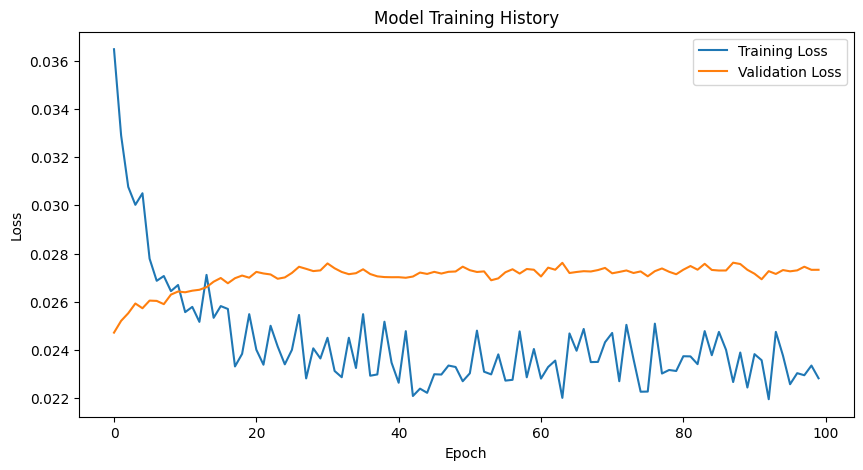


Training completed!
Final training loss: 0.0228
Final validation loss: 0.0273


In [ ]:
train_loader, val_loader, scaler = prepare_data(X, y)

# Initialize model
input_dim = X.shape[1]
n_stocks = y.shape[1]
model = DualStreamPortfolioOptimizer(input_dim=input_dim, n_stocks=n_stocks)

# Train model
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\nTraining completed!")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

Recommended Portfolio Allocation:
----------------------------------------
AAPL  :  14.69%
MSFT  :  10.52%
GOOG  :  12.14%
AMZN  :  17.94%
NVDA  :  11.37%
META  :  15.32%
TSLA  :  18.02%
----------------------------------------
Sum of weights: 1.0000


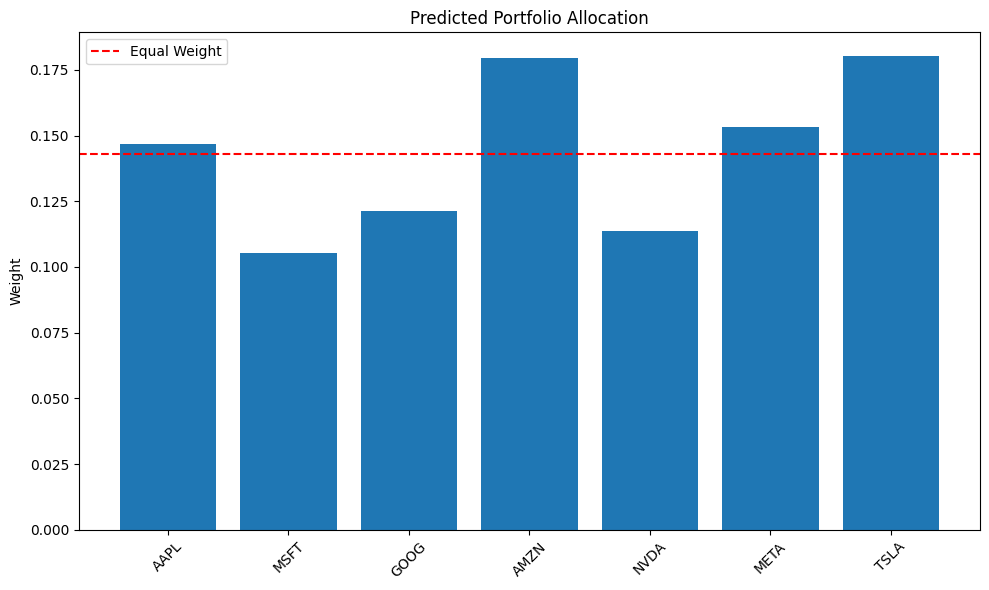

In [ ]:
model.eval()

# Get the most recent data point
latest_data = torch.FloatTensor(scaler.transform(X[-1:]))

# Make prediction
with torch.no_grad():
    predicted_weights = model(latest_data)

# Convert to numpy for easier handling
predicted_weights = predicted_weights.numpy()[0]

# Print recommended portfolio allocation
print("Recommended Portfolio Allocation:")
print("-" * 40)
for ticker, weight in zip(mag_seven, predicted_weights):
    print(f"{ticker:<6}: {weight:>7.2%}")
print("-" * 40)
print(f"Sum of weights: {np.sum(predicted_weights):.4f}")

# Visualize allocation
plt.figure(figsize=(10, 6))
plt.bar(mag_seven, predicted_weights)
plt.title('Predicted Portfolio Allocation')
plt.xticks(rotation=45)
plt.ylabel('Weight')
plt.axhline(y=1/len(mag_seven), color='r', linestyle='--', label='Equal Weight')
plt.legend()
plt.tight_layout()
plt.show()


Strategy Performance Comparison (2023)
--------------------------------------------------
Strategy           Fitness  Relative to EW
--------------------------------------------------
NVDA                1.7537            5.6%
META                1.6961            2.2%
Equal Weight        1.6602            0.0%
ML Model            1.5394           -7.3%
AAPL                1.2398          -25.3%
TSLA                1.2097          -27.1%
AMZN                1.1480          -30.9%
MSFT                1.1367          -31.5%
GOOG                1.0038          -39.5%


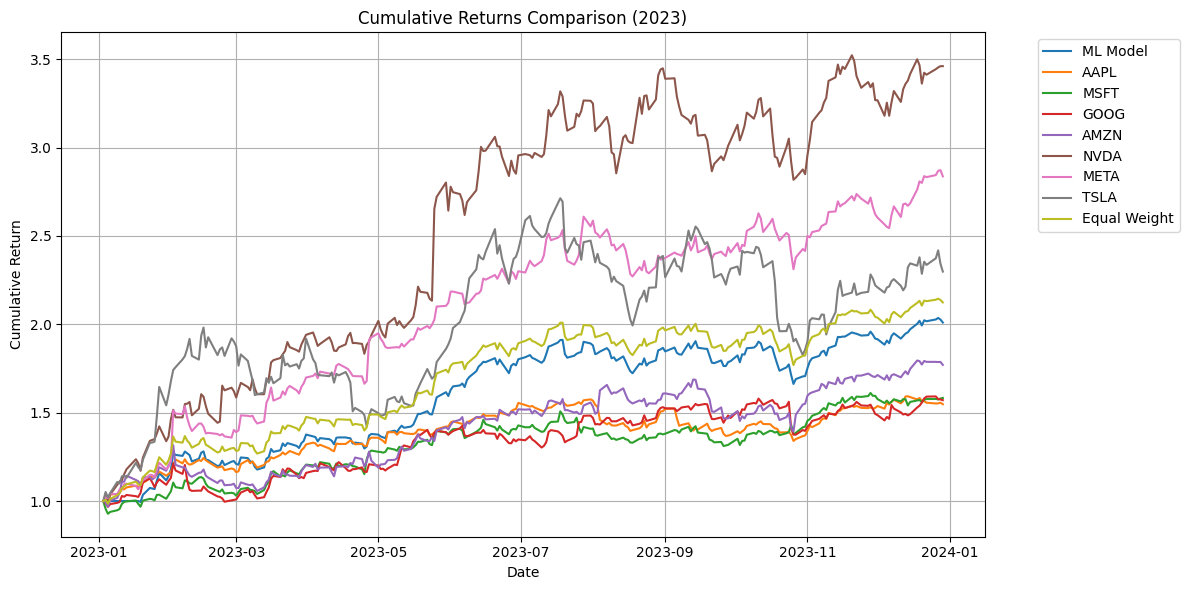


Detailed Performance Metrics
--------------------------------------------------
              ML Model   AAPL   MSFT   GOOG   AMZN    NVDA    META    TSLA  Equal Weight
Total Return    101.03  54.80  58.35  57.11  77.04  246.10  183.76  129.86        112.39
Annual Vol       26.54  19.92  25.07  30.55  32.96   48.36   39.75   52.54         26.11
Sharpe Ratio      2.64   2.11   1.81   1.51   1.79    2.74    2.74    1.78          2.89
Max Drawdown    -13.05 -14.93 -12.99 -17.88 -19.64  -18.29  -12.97  -32.72        -11.93


In [ ]:
# Backtesting cell

def run_strategy_backtest(stock_data, strategy_weights, strategy_name):
    """
    Run backtest for a given strategy

    Parameters:
    stock_data (pd.DataFrame): Daily stock prices
    strategy_weights (np.array): Weight matrix (n_days x n_stocks)
    strategy_name (str): Name of the strategy

    Returns:
    tuple: (fitness_score, daily_returns)
    """
    daily_returns = stock_data.pct_change()
    portfolio_returns = np.sum(strategy_weights * daily_returns, axis=1)
    fitness_score = calculate_fitness(portfolio_returns.dropna().values)
    return fitness_score, portfolio_returns

# Get 2023 data
start_date = '2023-01-01'
end_date = '2023-12-31'
lookback_days = 10

stock_data = pd.DataFrame()
for ticker in mag_seven:
    ticker_obj = yf.Ticker(ticker)
    hist = ticker_obj.history(start=start_date, end=end_date)
    stock_data[ticker] = hist['Close']

# Initialize results storage
results = []
returns_dict = {}

# 1. Test ML Model Strategy
model.eval()
n_days = len(stock_data)
ml_weights = np.zeros((n_days, len(mag_seven)))

# Generate predictions for each day
with torch.no_grad():
    for t in range(lookback_days, n_days):
        # Prepare input data
        hist_returns = stock_data.pct_change().iloc[t-lookback_days:t].values.flatten()
        input_data = torch.FloatTensor(scaler.transform(hist_returns.reshape(1, -1)))

        # Get prediction
        prediction = model(input_data).numpy()[0]
        ml_weights[t] = prediction

ml_fitness, ml_returns = run_strategy_backtest(stock_data, ml_weights, "ML Model")
results.append(("ML Model", ml_fitness))
returns_dict["ML Model"] = ml_returns

# 2. Test Individual Stock Strategies
for i, ticker in enumerate(mag_seven):
    weights = np.zeros((n_days, len(mag_seven)))
    weights[:, i] = 1
    fitness, returns = run_strategy_backtest(stock_data, weights, ticker)
    results.append((ticker, fitness))
    returns_dict[ticker] = returns

# 3. Test Equal Weight Strategy
equal_weights = np.ones((n_days, len(mag_seven))) / len(mag_seven)
eq_fitness, eq_returns = run_strategy_backtest(stock_data, equal_weights, "Equal Weight")
results.append(("Equal Weight", eq_fitness))
returns_dict["Equal Weight"] = eq_returns

# Print results
print("\nStrategy Performance Comparison (2023)")
print("-" * 50)
print(f"{'Strategy':<15} {'Fitness':>10} {'Relative to EW':>15}")
print("-" * 50)

# Sort results by fitness score
results.sort(key=lambda x: x[1], reverse=True)
equal_weight_fitness = eq_fitness  # Store for relative comparison

for strategy, fitness in results:
    relative_perf = (fitness / equal_weight_fitness - 1) * 100
    print(f"{strategy:<15} {fitness:>10.4f} {relative_perf:>14.1f}%")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
for strategy, returns in returns_dict.items():
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns.index, cumulative_returns.values, label=strategy)

plt.title('Cumulative Returns Comparison (2023)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional performance metrics
print("\nDetailed Performance Metrics")
print("-" * 50)
metrics_dict = {}

for strategy, returns in returns_dict.items():
    returns = returns.dropna()

    # Calculate metrics
    total_return = (1 + returns).prod() - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252 - 0.04) / annual_vol
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min()

    metrics_dict[strategy] = {
        'Total Return': total_return * 100,
        'Annual Vol': annual_vol * 100,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown * 100
    }

# Convert to DataFrame for pretty printing
metrics_df = pd.DataFrame(metrics_dict).round(2)
print(metrics_df.to_string())